<a href="https://colab.research.google.com/github/datasciencedani/ml-zoomcamp-gcp/blob/main/nbs/homework/06_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow with GPU

In this homework, we'll build a model for predicting if we have an image of a bee or a wasp. For this, we will use the ["Bee or Wasp?" dataset](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp/data) that was obtained from Kaggle and slightly rebuilt.

### Dataset

The rebuilt dataset contains around 2500 images of bees and around 2100 images of wasps. It contains separate folders for training and test sets:

```
data
|__train
|   |___bee
|   |___wasp
|
|__test
   |___bee
   |___wasp
```

You can find the data in the following link:

```
https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip
```

We copied the dataset to Google Drive to be able to mount our drive in a Colab notebook (where we can use free GPUs).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

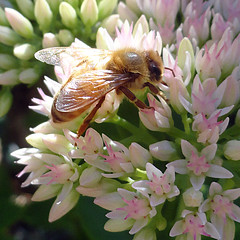

In [ ]:
path = '/content/drive/MyDrive/PROJECTS/[2023] ML ZOOMCAMP/data/train/bee/20997149292_3b5fd09795_m.jpg'
load_img(path)

### Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Model

For this homework we will use Convolutional Neural Network (CNN). Like in the lectures, we'll use Keras.

You need to develop the model with following structure:

* The shape for input should be `(150, 150, 3)`
* Next, create a convolutional layer ([`Conv2D`](https://keras.io/api/layers/convolution_layers/convolution2d/)):
    * Use 32 filters
    * Kernel size should be `(3, 3)` (that's the size of the filter)
    * Use `'relu'` as activation
* Reduce the size of the feature map with max pooling ([`MaxPooling2D`](https://keras.io/api/layers/pooling_layers/max_pooling2d/))
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using a [`Flatten`](https://keras.io/api/layers/reshaping_layers/flatten/) layer
* Next, add a `Dense` layer with 64 neurons and `'relu'` activation
* Finally, create the `Dense` layer with 1 neuron - this will be the output
    * The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use [`SGD`](https://keras.io/api/optimizers/sgd/) with the following parameters:

* `SGD(lr=0.002, momentum=0.8)`

### Question 1

Since we have a binary classification problem, what is the best loss function for us?

* `mean squared error`
* `binary crossentropy`✅
* `categorical crossentropy`
* `cosine similarity`

In [ ]:
def create_model(learning_rate=0.002, momentum=0.8):
  '''Defines and compiles model.'''

  inputs = tf.keras.Input(shape=(150, 150, 3))
  x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(
      loss='binary_crossentropy',
      optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
      metrics=['accuracy'])
  return model

In [ ]:
model = create_model()

### Question 2

What's the number of parameters in the convolutional layer of our model? You can use the `summary` method for that.

* 1
* 65
* 896
* 11214912✅

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 175232)            0         
                                                                 
 dense_4 (Dense)             (None, 64)                11214912  
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                           

### Generators and Training

For the next two questions, use the following data generator for both train and test sets:

```python
ImageDataGenerator(rescale=1./255)
```

* We don't need to do any additional pre-processing for the images.
* When reading the data from train/test directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
* Use `batch_size=20`
* Use `shuffle=True` for both training and test sets.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    '/content/drive/MyDrive/PROJECTS/[2023] ML ZOOMCAMP/data/train',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary',
)

Found 3677 images belonging to 2 classes.


In [ ]:
train_ds.class_indices

{'bee': 0, 'wasp': 1}

In [ ]:
val_gen = ImageDataGenerator(rescale=1./255)

val_ds = val_gen.flow_from_directory(
    '/content/drive/MyDrive/PROJECTS/[2023] ML ZOOMCAMP/data/test',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary',
)

Found 918 images belonging to 2 classes.


In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
  )

Epoch 1/10
184/184 [==============================] - 16s 85ms/step - loss: 0.6754 - accuracy: 0.5583 - val_loss: 0.6315 - val_accuracy: 0.6612
Epoch 2/10
184/184 [==============================] - 14s 76ms/step - loss: 0.6317 - accuracy: 0.6315 - val_loss: 0.6000 - val_accuracy: 0.6307
Epoch 3/10
184/184 [==============================] - 14s 76ms/step - loss: 0.5881 - accuracy: 0.6900 - val_loss: 0.6343 - val_accuracy: 0.6144
Epoch 4/10
184/184 [==============================] - 14s 77ms/step - loss: 0.5428 - accuracy: 0.7367 - val_loss: 0.5359 - val_accuracy: 0.7440
Epoch 5/10
184/184 [==============================] - 16s 88ms/step - loss: 0.5106 - accuracy: 0.7672 - val_loss: 0.5412 - val_accuracy: 0.7277
Epoch 6/10
184/184 [==============================] - 14s 75ms/step - loss: 0.4799 - accuracy: 0.7849 - val_loss: 0.5079 - val_accuracy: 0.7625
Epoch 7/10
184/184 [==============================] - 14s 75ms/step - loss: 0.4622 - accuracy: 0.7871 - val_loss: 0.5417 - val_accuracy:

In [ ]:
model.save('/content/drive/MyDrive/PROJECTS/[2023] ML ZOOMCAMP/model.keras')

### Question 3

What is the median of training accuracy for all the epochs for this model?

* 0.20
* 0.40
* 0.60
* 0.80✅

In [ ]:
model_bis = tf.keras.models.load_model('/content/drive/MyDrive/PROJECTS/[2023] ML ZOOMCAMP/model.keras')

In [ ]:
from statistics import median, stdev

median(history.history['accuracy'])

0.776040256023407

### Question 4

What is the standard deviation of training loss for all the epochs for this model?

* 0.031
* 0.061
* 0.091✅
* 0.131

In [ ]:
stdev(history.history['loss'])

0.09746706578749183

### Data Augmentation

For the next two questions, we'll generate more data using data augmentations.

Add the following augmentations to your training data generator:

* `rotation_range=50,`
* `width_shift_range=0.1,`
* `height_shift_range=0.1,`
* `zoom_range=0.1,`
* `horizontal_flip=True,`
* `fill_mode='nearest'`

In [ ]:
train_gen_aug = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
    )

train_ds_aug = train_gen_aug.flow_from_directory(
    '/content/drive/MyDrive/PROJECTS/[2023] ML ZOOMCAMP/data/train',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary',
)

Found 3677 images belonging to 2 classes.


In [ ]:
val_gen_aug = ImageDataGenerator(rescale=1./255)

val_ds_aug = val_gen_aug.flow_from_directory(
    '/content/drive/MyDrive/PROJECTS/[2023] ML ZOOMCAMP/data/test',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary',
)

Found 918 images belonging to 2 classes.


### Question 5

Let's train our model for 10 more epochs using the same code as previously.
> **Note:** make sure you don't re-create the model - we want to continue training the model
we already started training.

What is the mean of test loss for all the epochs for the model trained with augmentations?

* 0.18
* 0.48 ✅
* 0.78
* 0.108

In [ ]:
with tf.device('/device:GPU:0'):
  history_bis = model_bis.fit(
    train_ds_aug,
    epochs=10,
    validation_data=val_ds_aug,
  )

Epoch 1/10
184/184 [==============================] - 37s 192ms/step - loss: 0.5022 - accuracy: 0.7604 - val_loss: 0.4823 - val_accuracy: 0.7745
Epoch 2/10
184/184 [==============================] - 35s 190ms/step - loss: 0.4862 - accuracy: 0.7770 - val_loss: 0.5235 - val_accuracy: 0.7571
Epoch 3/10
184/184 [==============================] - 37s 204ms/step - loss: 0.4796 - accuracy: 0.7792 - val_loss: 0.5944 - val_accuracy: 0.7211
Epoch 4/10
184/184 [==============================] - 35s 190ms/step - loss: 0.4842 - accuracy: 0.7786 - val_loss: 0.4943 - val_accuracy: 0.7778
Epoch 5/10
184/184 [==============================] - 35s 189ms/step - loss: 0.4717 - accuracy: 0.7843 - val_loss: 0.5288 - val_accuracy: 0.7462
Epoch 6/10
184/184 [==============================] - 37s 202ms/step - loss: 0.4693 - accuracy: 0.7822 - val_loss: 0.5020 - val_accuracy: 0.7462
Epoch 7/10
184/184 [==============================] - 35s 188ms/step - loss: 0.4648 - accuracy: 0.7868 - val_loss: 0.4752 - val_ac

In [ ]:
from statistics import mean

mean(history.history['val_loss'])

0.5475754290819168

### Question 6

What's the average of test accuracy for the last 5 epochs (from 6 to 10)
for the model trained with augmentations?

* 0.38
* 0.58
* 0.78 ✅
* 0.98

In [ ]:
mean(history.history['val_accuracy'][5:])

0.7581699371337891